In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score,
    make_scorer,
    roc_curve,
    confusion_matrix,
    precision_recall_curve,
    auc,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold

ap_pro_data = pd.read_csv("./resources/datasets/ap_pro/continuous.csv")
ap_pro_data.head()

,VisitID,RecordID,Age,Sex,PainDur,PainSite,PainType,Vomiting,PrevVis,Temp,TendSite,Guard,RebTend,PainShift,WBC,Triage,Observer
0,1,1,"13,08",female,"144,00",lower_abdomen,constant,yes,no,"37,40",lower_abdomen,no,no,no,?,discharge,discharge
1,2,2,"4,77",female,"120,00",lower_abdomen,intermittent,no,no,"35,70",other,no,no,no,?,discharge,discharge
2,3,3,"11,23",male,"11,00",lower_abdomen,constant,no,no,"35,90",lower_abdomen,no,yes,no,"18,60",consult,observation
3,4,4,"11,01",female,"24,00",other,constant,no,yes,"37,80",other,no,no,no,"17,00",discharge,discharge
4,5,5,"2,41",female,"3,00",other,intermittent,yes,no,"38,20",other,no,no,no,?,discharge,observation


In [2]:
continuous_attributes = ["Age", "PainDur", "Temp", "WBC"]
categorical_attributes = ["Sex", "PainSite", "PainType", "TendSite"]
binary_attributes = ["Vomiting", "PrevVis", "Guard", "RebTend", "PainShift"]

In [3]:
def prepare_data(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    df.drop(columns=["VisitID", "RecordID", "Observer"], inplace=True)
    df.replace("?", 2137, inplace=True)
    # df.dropna(axis=1, thresh=len(ap_pro_data) // 2, inplace=True)

    df["Triage"] = df["Triage"].apply(lambda x: 1 if x == "consult" else 0)

    df = pd.get_dummies(df, columns=categorical_attributes)

    for attribute in continuous_attributes:
        df[attribute] = df[attribute].apply(lambda x: float(str(x).replace(",", ".")))

    for attribute in binary_attributes:
        df[attribute] = df[attribute].apply(lambda x: 1 if x == "yes" or x == "constant" else 0)

    return df.drop(columns=["Triage"]), df["Triage"]


X, y = prepare_data(ap_pro_data)
X.head()

,Age,PainDur,Vomiting,PrevVis,Temp,Guard,RebTend,PainShift,WBC,Sex_female,...,PainSite_RLQ,PainSite_lower_abdomen,PainSite_other,PainType_2137,PainType_constant,PainType_intermittent,TendSite_2137,TendSite_RLQ,TendSite_lower_abdomen,TendSite_other
0,13.08,144.0,1,0,37.4,0,0,0,2137.0,True,...,False,True,False,False,True,False,False,False,True,False
1,4.77,120.0,0,0,35.7,0,0,0,2137.0,True,...,False,True,False,False,False,True,False,False,False,True
2,11.23,11.0,0,0,35.9,0,1,0,18.6,False,...,False,True,False,False,True,False,False,False,True,False
3,11.01,24.0,0,1,37.8,0,0,0,17.0,True,...,False,False,True,False,True,False,False,False,False,True
4,2.41,3.0,1,0,38.2,0,0,0,2137.0,True,...,False,False,True,False,False,True,False,False,False,True


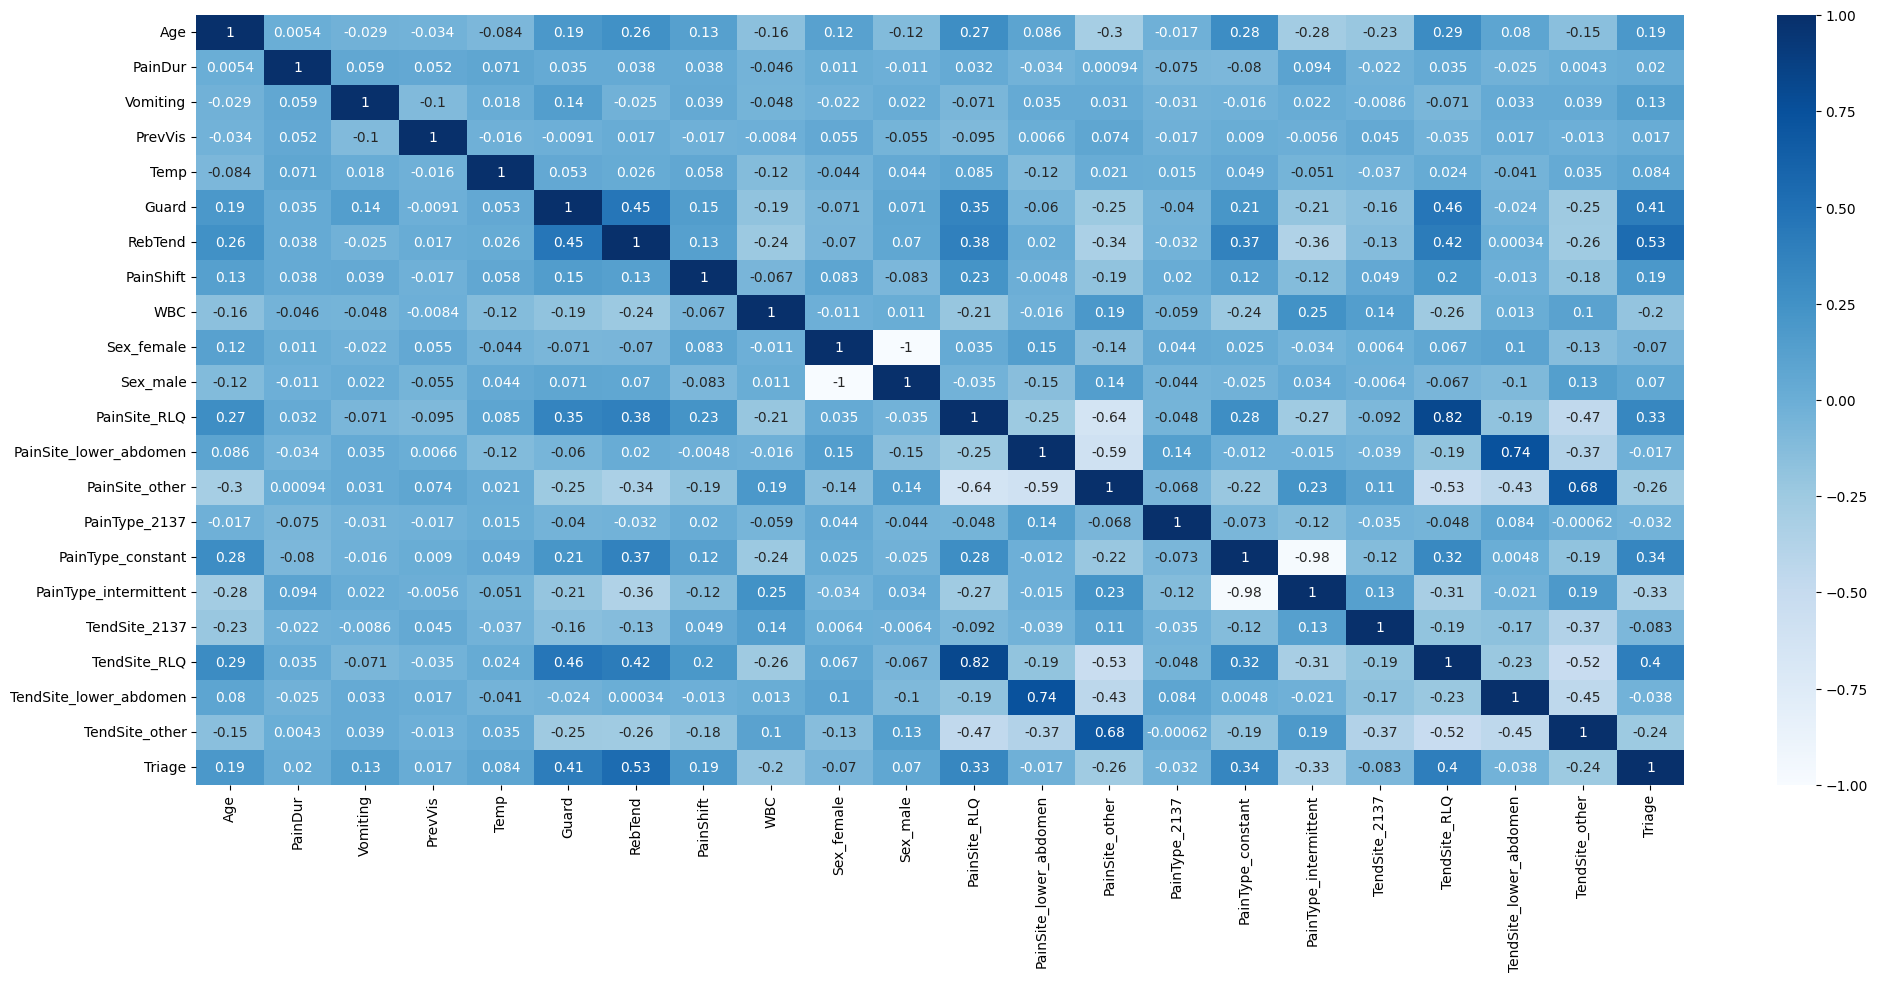

In [4]:
def show_correlations(df: pd.DataFrame) -> None:
    plt.figure(figsize=(24, 10))
    correlation_matrix = df.corr(method="kendall")
    sns.heatmap(correlation_matrix, annot=True, cmap="Blues")


show_correlations(pd.concat([X, y], axis=1))

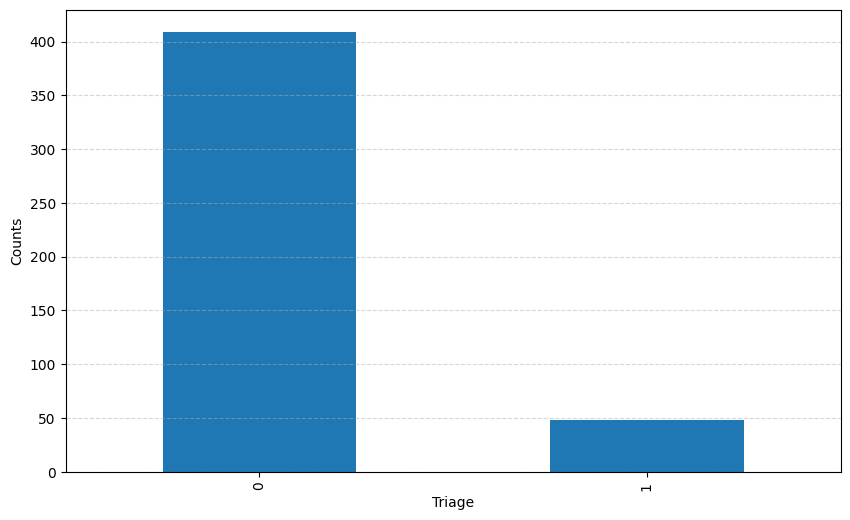

In [5]:
def show_class_distribution(df: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 6))
    df.value_counts().plot(kind="bar")
    plt.xlabel("Triage")
    plt.ylabel("Counts")
    plt.grid(axis="y", linestyle="--", alpha=0.5)


show_class_distribution(y)

In [6]:
def get_baseline_classifier() -> Pipeline:
    return LogisticRegression(max_iter=10000)


def auprc_score(y: np.ndarray, y_pred: np.ndarray) -> float:
    precision, recall, _ = precision_recall_curve(y, y_pred)
    return auc(recall, precision)


def get_target_classifier(X: np.ndarray, y: np.ndarray) -> Pipeline:
    pipeline = Pipeline(
        [
            ("smote", SMOTE(random_state=42)),
            ("rf", RandomForestClassifier(class_weight="balanced", random_state=42)),
        ]
    )
    param_grid = {
        "rf__n_estimators": [50, 75, 100, 200],
        "rf__max_depth": [None, 5, 10, 15, 20],
        "rf__min_samples_split": [2, 4, 6, 8],
        "rf__min_samples_leaf": [2, 4, 6, 8],
    }
    auprc_scorer = make_scorer(auprc_score, response_method="predict_proba")
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

    grid_search = GridSearchCV(pipeline, param_grid, scoring=auprc_scorer, cv=rskf, n_jobs=-1)
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

    return grid_search.best_estimator_

In [7]:
X, y = X.to_numpy(), y.to_numpy()

baseline_classifier = get_baseline_classifier()
target_classifier = get_target_classifier(X, y)

classifiers = {"baseline": baseline_classifier, "target": target_classifier}

target_classifier.fit(X, y)

{'rf__max_depth': None, 'rf__min_samples_leaf': 6, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=6, n_estimators=50,
                                        random_state=42))])

In [8]:
def calculate_risk_thresholds(y: np.ndarray, y_pred: np.ndarray) -> tuple[float, float]:
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    # sensitivity, specificity = tpr, 1 - fpr
    medium_risk = thresholds[tpr >= 0.99][0]
    high_risk = thresholds[fpr >= (1 - 0.9)][0]

    return medium_risk, high_risk


def calculate_rates(
    y: np.ndarray, y_pred: np.ndarray, positives: float, negatives: float
) -> tuple[float, float, float, float]:
    tn, tp, fn, fp = confusion_matrix(y, y_pred).ravel()
    # positives, negatives = tp + fn, tn + fp

    tpr = tp / positives  # sensitivity
    fnr = fn / positives  # miss_rate
    fpr = fp / negatives  # fall_out
    tnr = tn / negatives  # specificity

    return tpr, fnr, fpr, tnr


def assess_classifier(X: np.ndarray, y: np.ndarray, classifier) -> dict[str, list[float]]:
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

    auprc, auroc = [], []
    negatives, positives, unknowns = [], [], []
    rates, matrices = [], []

    for train, test in rskf.split(X, y):
        classifier.fit(X[train], y[train])

        y_pred_proba_train = classifier.predict_proba(X[train])[:, 1]
        medium_risk, high_risk = calculate_risk_thresholds(y[train], y_pred_proba_train)

        y_pred_proba = classifier.predict_proba(X[test])[:, 1]
        auprc.append(auprc_score(y[test], y_pred_proba))
        auroc.append(roc_auc_score(y[test], y_pred_proba))

        negative, positive, unknown = 0, 0, 0
        for response in y_pred_proba:
            if response < medium_risk:
                negative += 1
            elif response >= high_risk:
                positive += 1
            else:
                unknown += 1

        number_of_samples: int = len(X[test])
        negatives.append(negative / number_of_samples)
        positives.append(positive / number_of_samples)
        unknowns.append(unknown / number_of_samples)

        y_pred = classifier.predict(X[test])
        rates.append(calculate_rates(y[test], y_pred, positive, negative))
        matrices.append(confusion_matrix(y[test], y_pred))

    return {
        "auprc": np.mean(auprc),
        "auroc": np.mean(auroc),
        "negatives": np.mean(negatives),
        "positives": np.mean(positives),
        "unknowns": np.mean(unknowns),
        "rates": np.mean(rates, axis=0),
        "confusion_matrix": np.mean(matrices, axis=0),
    }

In [9]:
results = {name: assess_classifier(X, y, classifier) for name, classifier in classifiers.items()}
results

{'baseline': {'auprc': 0.6098044390990071,
  'auroc': 0.8935782394860985,
  'negatives': 0.24469660774008598,
  'positives': 0.1736263736263736,
  'unknowns': 0.5816770186335403,
  'rates': array([0.1324438 , 0.32783822, 0.28005725, 5.12185576]),
  'confusion_matrix': array([[79.66666667,  2.13333333],
         [ 5.        ,  4.6       ]])},
 'target': {'auprc': 0.6223929274254846,
  'auroc': 0.9098353909465021,
  'negatives': 0.6025720656155439,
  'positives': 0.27130116260551046,
  'unknowns': 0.12612677177894568,
  'rates': array([0.15267974, 0.19480904, 0.09866089, 1.43737662]),
  'confusion_matrix': array([[78.        ,  3.8       ],
         [ 4.33333333,  5.26666667]])}}

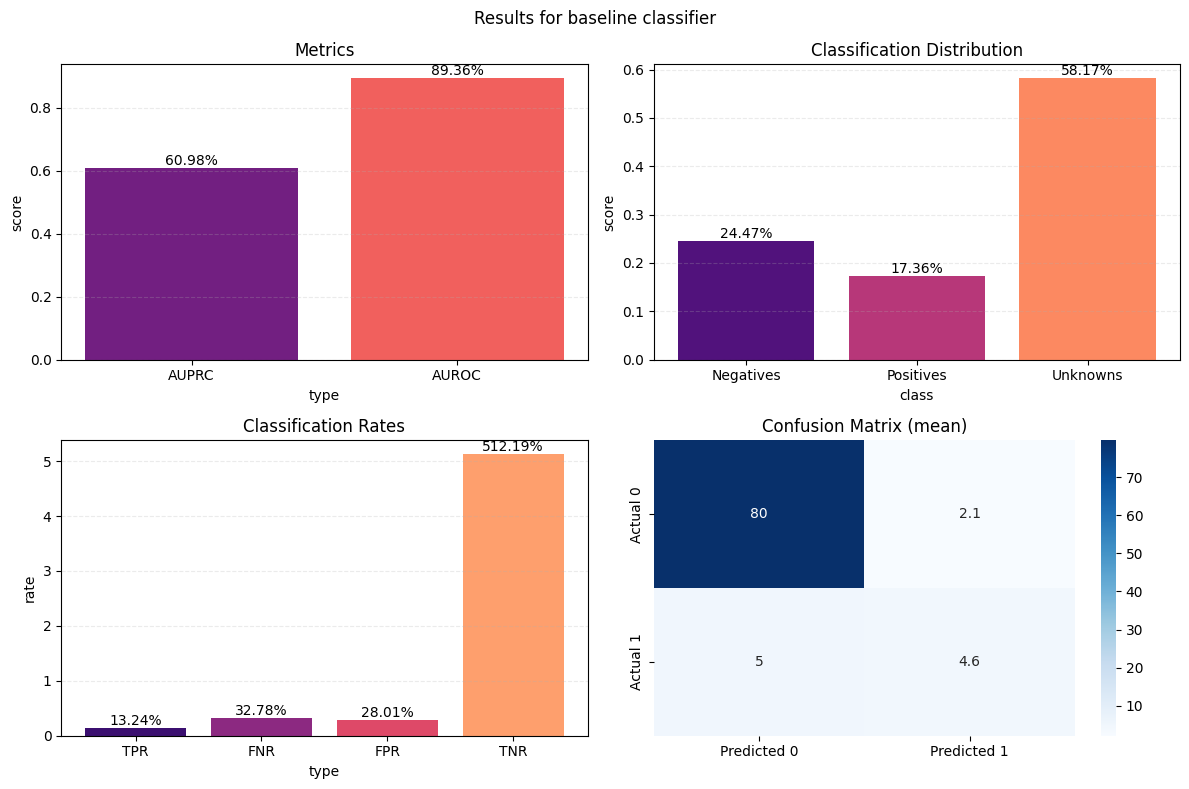

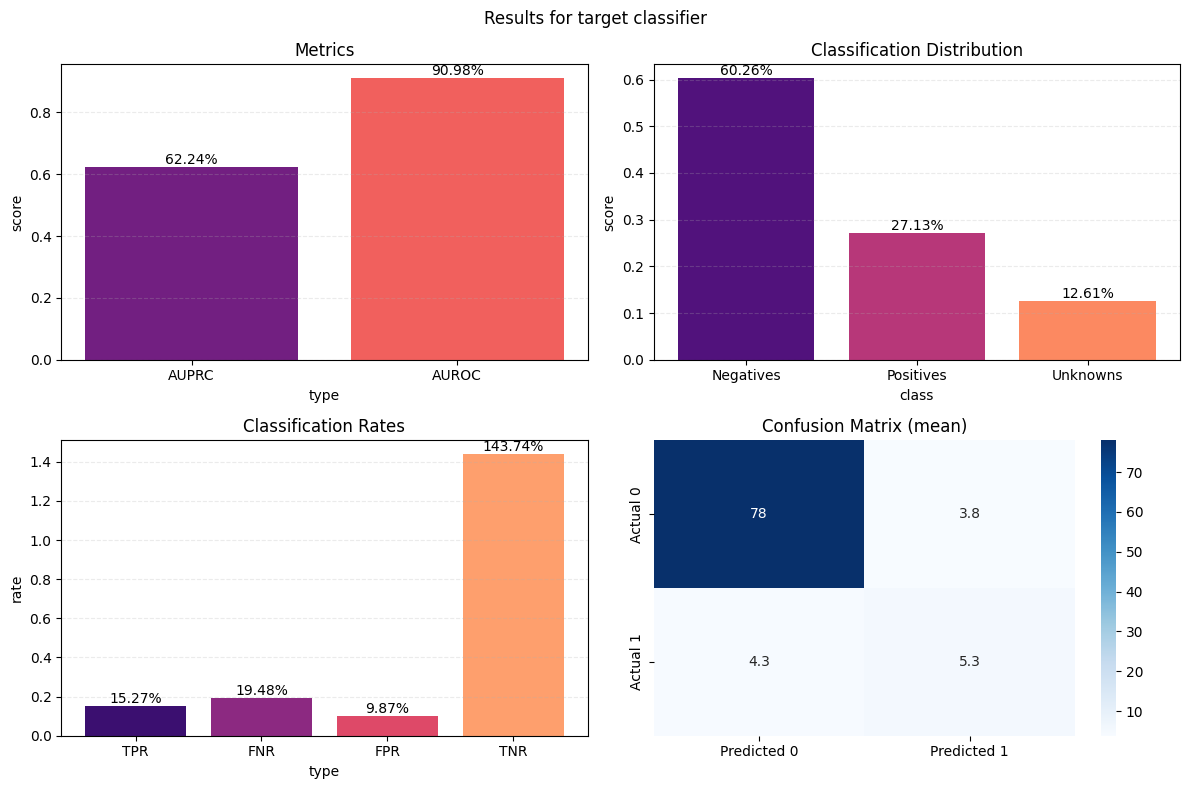

In [10]:
def show_result(result: dict, classifier: str) -> None:
    two_colors, three_colors, four_colors = [
        sns.color_palette("magma", number) for number in (2, 3, 4)
    ]
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    ax1, ax2, ax3, ax4 = axs.flatten()

    ax1.bar(
        ["AUPRC", "AUROC"],
        [result["auprc"], result["auroc"]],
        color=two_colors,
    )
    ax1.grid(axis="y", linestyle="--", alpha=0.25)
    for i, value in enumerate([result["auprc"], result["auroc"]]):
        ax1.text(i, value, f"{value * 100:.2f}%", ha="center", va="bottom")
    ax1.set_xlabel("type")
    ax1.set_ylabel("score")
    ax1.set_title("Metrics")

    ax2.bar(
        ["Negatives", "Positives", "Unknowns"],
        [result["negatives"], result["positives"], result["unknowns"]],
        color=three_colors,
    )
    ax2.grid(axis="y", linestyle="--", alpha=0.25)
    for i, value in enumerate([result["negatives"], result["positives"], result["unknowns"]]):
        ax2.text(i, value, f"{value * 100:.2f}%", ha="center", va="bottom")
    ax2.set_xlabel("class")
    ax2.set_ylabel("score")
    ax2.set_title("Classification Distribution")

    ax3.bar(["TPR", "FNR", "FPR", "TNR"], result["rates"], color=four_colors)
    ax3.grid(axis="y", linestyle="--", alpha=0.25)
    for i, value in enumerate(result["rates"]):
        ax3.text(i, value, f"{value * 100:.2f}%", ha="center", va="bottom")
    ax3.set_xlabel("type")
    ax3.set_ylabel("rate")
    ax3.set_title("Classification Rates")

    sns.heatmap(result["confusion_matrix"], annot=True, cmap="Blues", ax=ax4)
    ax4.set_xticklabels(["Predicted 0", "Predicted 1"])
    ax4.set_yticklabels(["Actual 0", "Actual 1"])
    ax4.set_title("Confusion Matrix (mean)")

    fig.suptitle(f"Results for {classifier} classifier")
    plt.tight_layout()
    plt.show()


for classifier, result in results.items():
    show_result(result, classifier)